In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import List
from dataclasses import dataclass
import inspect
import os, io, pickle
import copy
import math

if hasattr(__builtins__,'__IPYTHON__'):
    from tqdm.notebook import tqdm
else:
    from tqdm import tqdm

In [2]:
@dataclass
class GPTConfig:
    # block_size: int = 1024
    # # GPT-2 vocab_size of 50257, padded up to nearest multiple of 64 for efficiency
    # vocab_size: int = 50304 
    # n_layer: int = 12
    # n_head: int = 12
    # n_embd: int = 768
    # dropout: float = 0.0
    # # True: bias in Linears and LayerNorms, like GPT-2. False: a bit better and faster
    # bias: bool = True 

    block_size: int = 128
    # GPT-2 vocab_size of 50257, padded up to nearest multiple of 64 for efficiency
    vocab_size: int = 128 
    n_layer: int = 2
    n_head: int = 2
    n_embd: int = 64
    dropout: float = 0.0
    # True: bias in Linears and LayerNorms, like GPT-2. False: a bit better and faster
    bias: bool = True 
    

In [16]:
@dataclass
class TrainConfig:
    batch_size: int = 8
    dtype: str = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16'
    device: str = 'gpu' if torch.cuda.is_available() else 'cpu'
    warmup_iters = 2000
    learning_rate = 6e-4
    lr_decay_iters = 600000
    min_lr = 6e-5    
    weight_decay = 1e-1
    beta1 = 0.9
    beta2 = 0.95
    device = 'cpu'

In [4]:
class Tokenizer():
    '''
    Very simple tokenizer that convers integer to ASCII
    [0, 7] can be saved for special tokens if needed as they are not viewable
    '''
    __slots__ = ['vocab_size', 'special_enc', 'special_dec']
    
    def __init__(self, specials: List[str] = ['<?>']) -> None:
        self.vocab_size = 128
        self.special_enc = dict((c, i) for i, c in enumerate(specials))
        self.special_dec = dict((i, c) for i, c in enumerate(specials))
        print(self.special_enc, self.special_dec)
            
    def encode(self, x: List[str]) -> List[int]:
        ret = []
        for xx in x:
            if xx in self.special_enc:
                ret.append(self.special_enc[xx])
            elif 7 < ord(xx) < self.vocab_size:
                ret.append(ord(xx))
            else:
                ret.append(0)
        return ret
    
    def decode(self, x: List[int]) -> List[str]:
        ret = []
        for xx in x:
            if xx in self.special_dec:
                ret.append(self.special_dec[xx])
            elif 7 < xx < self.vocab_size:
                ret.append(chr(xx))
            else:
                ret.append(self.special_dec[0])
        return ret


tokenizer = Tokenizer()
# print(tokenizer.encode("This is a sentence"))
# print(''.join(tokenizer.decode(tokenizer.encode("This is a sentence"))))
# print(''.join(tokenizer.decode([0] + tokenizer.encode("This is a sentence"))))

{'<?>': 0} {0: '<?>'}


In [5]:
class LayerNorm(nn.Module):
    """ LayerNorm but with an optional bias. PyTorch doesn't support simply bias=False """

    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None

    def forward(self, input):
        return F.layer_norm(input, self.weight.shape, self.weight, self.bias, 1e-5)

In [6]:
class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        # linear is usually multiplied by 4
        # here we have 2 for efficiency
        self.c_fc    = nn.Linear(config.n_embd, 2 * config.n_embd, bias=config.bias)
        self.gelu    = nn.GELU()
        self.c_proj  = nn.Linear(2 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x
    
# mlp = MLP(GPTConfig)
# print(mlp(torch.rand(2, 2, 64)).shape)
# del mlp

In [7]:
class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        # regularization
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.dropout = config.dropout


    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k, v  = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        # efficient attention using Flash Attention CUDA kernels
        # y.shape (B, nh, T, hs)
        y = torch.nn.functional.scaled_dot_product_attention(q, k, v, attn_mask=None, 
                                                             dropout_p=self.dropout if self.training else 0, 
                                                             is_causal=True)
        
        # re-assemble all head outputs side by side
        y = y.transpose(1, 2).contiguous().view(B, T, C) 

        # output projection
        y = self.resid_dropout(self.c_proj(y))
        return y
    
# catt = CausalSelfAttention(GPTConfig)
# print(catt(torch.rand(2, 2, 64)).shape)
# del catt

In [8]:
class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln_1 = LayerNorm(config.n_embd, bias=config.bias)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = LayerNorm(config.n_embd, bias=config.bias)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x
    
# block = Block(GPTConfig)
# print(block(torch.rand(2, 2, 64)).shape)
# del block

In [9]:
class PatchMerger(nn.Module):
    # https://github.com/lucidrains/vit-pytorch/blob/5578ac472faf3903d4739ba783f3875b77177e57/vit_pytorch/vit_with_patch_merger.py#L4

    def __init__(self, dim, num_tokens_out):
        super().__init__()
        self.scale = dim ** -0.5
        self.norm = nn.LayerNorm(dim)
        self.queries = nn.Parameter(torch.randn(num_tokens_out, dim))

    def forward(self, x):
        x = self.norm(x)
        # queries.shape: [BS, M, DIM]
        # x.shape: [BS, T, DIM]
        # out: [M, DIM] x [DIM, T] = [M, T]
        sim = torch.matmul(self.queries, x.transpose(-1, -2)) * self.scale
        # att.shape: [BS, M, T]
        attn = sim.softmax(dim = -1)
        # [M, T] x [T, DIM]
        return torch.matmul(attn, x)

In [10]:
class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            drop = nn.Dropout(config.dropout),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = LayerNorm(config.n_embd, bias=config.bias),
        ))
        
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        # https://paperswithcode.com/method/weight-tying
        self.transformer.wte.weight = self.lm_head.weight 
        # self.patchmerger = PatchMerger(config.n_embd, 16)
        # self.patchextend = PatchMerger(config.n_embd, 32)

        # init all weights
        self.apply(self._init_weights)
        # apply special scaled init to the residual projections, per GPT-2 paper
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/((2 * config.n_layer)**0.5))
        
        # report number of parameters
        print("number of parameters: %.2fM" % (self.get_num_params()/1e6,))

    def get_num_params(self, non_embedding=True):
        """
        Return the number of parameters in the model.
        For non-embedding count (default), the position embeddings get subtracted.
        The token embeddings would too, except due to the parameter sharing these
        params are actually used as weights in the final layer, so we include them.
        """
        n_params = sum(p.numel() for p in self.parameters())
        if non_embedding:
            n_params -= self.transformer.wpe.weight.numel()
        return n_params

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.config.block_size, f"Cannot forward sequence of length {t}, block size is only {self.config.block_size}"
        pos = torch.arange(0, t, dtype=torch.long, device=device) # shape (t)

        # forward the GPT model itself
        # token embeddings of shape (b, t, n_embd)
        tok_emb = self.transformer.wte(idx) 
        # position embeddings of shape (t, n_embd)
        pos_emb = self.transformer.wpe(pos) 
        # add position embeddings
        x = self.transformer.drop(tok_emb + pos_emb)
        
        # propagating through transformers
        for i, block in enumerate(self.transformer.h):
            x = block(x)
            # if i == 0: 
            #     x = self.patchmerger(x)
            # elif i == self.config.n_layer-2:
            #     x = self.patchextend(x)
                
        x = self.transformer.ln_f(x)

        if targets is not None:
            # if we are given some desired targets also calculate the loss
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
        else:
            # inference-time mini-optimization: only forward the lm_head on the very last position
            logits = self.lm_head(x[:, [-1], :]) # note: using list [-1] to preserve the time dim
            loss = None

        return logits, loss

    def crop_block_size(self, block_size):
        # model surgery to decrease the block size if necessary
        # e.g. we may load the GPT2 pretrained model checkpoint (block size 1024)
        # but want to use a smaller block size for some smaller, simpler model
        assert block_size <= self.config.block_size
        self.config.block_size = block_size
        self.transformer.wpe.weight = nn.Parameter(self.transformer.wpe.weight[:block_size])
        for block in self.transformer.h:
            if hasattr(block.attn, 'bias'):
                block.attn.bias = block.attn.bias[:,:,:block_size,:block_size]


    def configure_optimizers(self, weight_decay, learning_rate, betas, device_type):
        # start with all of the candidate parameters
        param_dict = {pn: p for pn, p in self.named_parameters()}
        # filter out those that do not require grad
        param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}
        # create optim groups. Any parameters that is 2D will be weight decayed, otherwise no.
        # i.e. all weight tensors in matmuls + embeddings decay, all biases and layernorms don't.
        decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
        nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]
        optim_groups = [
            {'params': decay_params, 'weight_decay': weight_decay},
            {'params': nodecay_params, 'weight_decay': 0.0}
        ]
        num_decay_params = sum(p.numel() for p in decay_params)
        num_nodecay_params = sum(p.numel() for p in nodecay_params)
        print(f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters")
        print(f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters")
        # Create AdamW optimizer and use the fused version if it is available
        fused_available = 'fused' in inspect.signature(torch.optim.AdamW).parameters
        use_fused = fused_available and device_type == 'cuda'
        extra_args = dict(fused=True) if use_fused else dict()
        optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=betas, **extra_args)
        print(f"using fused AdamW: {use_fused}")

        return optimizer


    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """
        Take a conditioning sequence of indices idx (LongTensor of shape (b,t)) and complete
        the sequence max_new_tokens times, feeding the predictions back into the model each time.
        Most likely you'll want to make sure to be in model.eval() mode of operation for this.
        """
        for _ in range(max_new_tokens):
            # if the sequence context is growing too long we must crop it at block_size
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
            # forward the model to get the logits for the index in the sequence
            logits, _ = self(idx_cond)
            # pluck the logits at the final step and scale by desired temperature
            logits = logits[:, -1, :] / temperature
            # optionally crop the logits to only the top k options
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            # apply softmax to convert logits to (normalized) probabilities
            probs = F.softmax(logits, dim=-1)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)
            # append sampled index to the running sequence and continue
            idx = torch.cat((idx, idx_next), dim=1)

        return idx
    

# gpt = GPT(GPTConfig)
# #gpt = torch.compile(gpt)
# out, loss = gpt(torch.ones((2, 8), dtype=torch.long))
# print(out.shape, loss)
# del gpt, out, loss

In [11]:
import os

datapath = os.path.join(
    '..', 
    'dataset',
    'tinyshakespeare.txt'
)

with open(datapath, 'r', encoding='utf-8') as f:
    text = f.read()

data = torch.tensor(tokenizer.encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - GPTConfig.block_size, (TrainConfig.batch_size,))
    x = torch.stack([data[i:i+GPTConfig.block_size] for i in ix])
    y = torch.stack([data[i+1:i+GPTConfig.block_size+1] for i in ix])
    x, y = x.to(TrainConfig.device), y.to(TrainConfig.device)
    return x, y

In [12]:
model = GPT(GPTConfig)

number of parameters: 0.08M


In [13]:
# x, y = get_batch('train')
# print(x.shape, y.shape)
# out, loss = model(x, y)
# print(out.shape, loss)

In [14]:
def get_lr(it):
    # 1) linear warmup for warmup_iters steps
    if it < TrainConfig.warmup_iters:
        return TrainConfig.learning_rate * it / TrainConfig.warmup_iters
    # 2) if it > lr_decay_iters, return min learning rate
    if it > TrainConfig.lr_decay_iters:
        return TrainConfig.min_lr
    # 3) in between, use cosine decay down to min learning rate
    decay_ratio = (it - TrainConfig.warmup_iters) / (TrainConfig.lr_decay_iters - TrainConfig.warmup_iters)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff ranges 0..1
    return TrainConfig.min_lr + coeff * (TrainConfig.learning_rate - TrainConfig.min_lr)

# import matplotlib.pyplot as plt
# x = list(range(100000))
# y = [get_lr(xx) for xx in x]
# plt.plot(x, y)

In [17]:
optimizer = model.configure_optimizers(TrainConfig.weight_decay, 
                                       TrainConfig.learning_rate, 
                                       (TrainConfig.beta1, TrainConfig.beta2), 
                                       TrainConfig.device)

num decayed parameter tensors: 10, with 81,920 parameters
num non-decayed parameter tensors: 18, with 1,536 parameters
using fused AdamW: False


In [18]:
# https://github.com/pytorch/pytorch/issues/16797#issuecomment-633423219
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else:
            return super().find_class(module, name)


def train_fn(model: nn.Module,
             epoch: int,
             optimizer: torch.optim.Optimizer,
             savepath: str = None,
             device='cpu'):

    best_weight = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    train_phases = ['train', 'val']
    losses = {phase: [] for phase in train_phases}

    if savepath and os.path.exists(savepath):
        # Try loading the model and weight
        try:
            with open(savepath, 'rb') as filehandler:
                prev_train = CPU_Unpickler(filehandler).load()
                best_weight = prev_train['best_weight']
                model.load_state_dict(best_weight, strict=False)
                losses = prev_train['losses']
                best_loss = prev_train['best_loss']
                optimizer = prev_train['optimizer'] 
                print(f"Loaded model with loss: {best_loss:0.4f}")
        except:
            print(f"Could not load from path: {savepath}")


    for e in range(epoch):
        for phase in train_phases:
            is_training = (phase == 'train')
            model.train() if is_training else model.eval()
            loss, dats = 0., 0.,
            tqdm_prog = tqdm(range(1000))

            for _ in tqdm_prog:
                x, y = get_batch(phase)
                #x, y = x.to(device), y.to(device)

                with torch.set_grad_enabled(phase == 'train'):
                    _, batch_loss = model(x, y)
                    
                    if phase == 'train':
                        optimizer.zero_grad()
                        batch_loss.backward()
                        optimizer.step()

                # Stats
                dats += x.size(0)
                loss += batch_loss.item() * x.size(0)
                tqdm_prog.set_description(f"Epoch {e+1} [{phase.upper()}]: Loss: {loss/dats:.4f}")

            epoch_loss = loss / dats
            losses[phase].append(epoch_loss)

            if phase == "val" and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_weight = copy.deepcopy(model.state_dict())
                if savepath:
                    with open(savepath, 'wb') as filehandler:
                        pickle.dump({
                            'best_weight': best_weight,
                            'best_loss': best_loss,
                            'losses': losses,
                            'optimizer': optimizer
                        }, filehandler)
                print(f"Best loss found: {best_loss:3.4f}")

    print(f'Best loss: {best_loss:3.4f}')
    model.load_state_dict(best_weight)

In [19]:
train_fn(model, 
         22,
         optimizer,
         os.path.join('..', 'logs', 'log.pkl'),
         'cpu')

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Best loss found: 2.4265


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Best loss found: 2.2558


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Best loss found: 2.1065


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Best loss found: 1.9907


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Best loss found: 1.9423


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Best loss found: 1.9043


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Best loss found: 1.8597


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Best loss found: 1.8528


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Best loss found: 1.8327


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Best loss found: 1.8239


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Best loss found: 1.8046


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Best loss found: 1.7898


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Best loss found: 1.7766


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Best loss found: 1.7723


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Best loss found: 1.7697


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Best loss found: 1.7674


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Best loss found: 1.7494


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Best loss found: 1.7466


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Best loss: 1.7466


Loaded model with loss: 1.7466


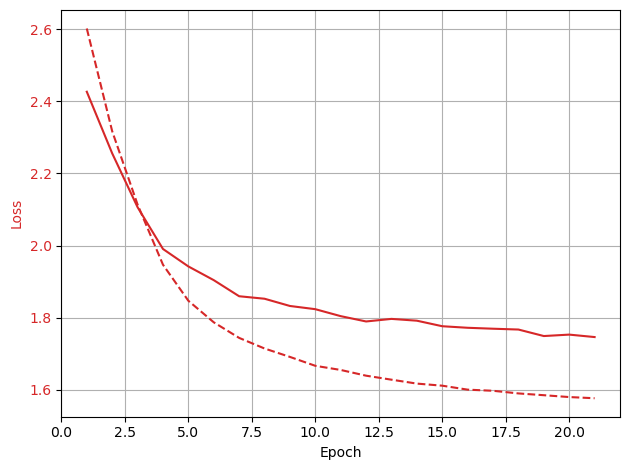

In [21]:
savepath = os.path.join(
    "..", "logs", "log.pkl"
)

def plot_graph(savepath):
    with open(savepath, 'rb') as filehandler:
        prev_train = CPU_Unpickler(filehandler).load()
        # best_weight = prev_train['best_weight']
        # model.load_state_dict(best_weight)
        losses = prev_train['losses']
        best_loss = prev_train['best_loss']
        print(f"Loaded model with loss: {best_loss:0.4f}")

    epochs = range(1, len(losses['train'])+1)
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color=color)
    ax1.plot(epochs, losses['train'], color=color, linestyle='dashed')
    ax1.plot(epochs, losses['val'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.grid()
    plt.show()

import matplotlib.pyplot as plt
plot_graph(savepath)

In [23]:
x = torch.tensor(tokenizer.encode("he is a"), dtype=torch.int).unsqueeze(0)
model.eval()
# model.generate(self, idx, max_new_tokens, temperature=1.0, top_k=None)
''.join(tokenizer.decode(model.generate(x, max_new_tokens=100).detach()[0].tolist()))

"he is armement?\nYour us and rungs give his your shall 'sword.\n\nWAULT:\nWhat to-rumpy and lives\nTon Embaled t"

In [ ]:
# import torchtext
# torchtext.datasets.WikiText103(root=os.path.join('..', 'wikitext'))